# Data Loading and Imports

In [2]:
from PIL import Image as PilImage
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from IPython.display import Image, display
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from sklearn.metrics import precision_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from keras.optimizers import Adam
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [3]:
image_dir = 'C:\\Users\\howar\\Desktop\\Capstone\\FloridaSnakePredictor\\Snake Photos'

In [4]:
all_images = set(f for f in os.listdir(image_dir) if f.endswith('.jpg'))

In [5]:
venomous_snakes = ["Florida Cottonmouth.jpg", "Florida Cottonmouth 1.jpg", "Dusky Pygmy Rattlesnake.jpg", "Dusky Pygmy Rattlesnake 1.jpg", "Eastern Diamond-backed Rattlesnake.jpg", "Eastern Diamond-backed Rattlesnake 1.jpg",  "Harlequin Coralsnake.jpg", "Harlequin Coralsnake 1.jpg", "Eastern Copperhead.jpg", "Eastern Copperhead 1.jpg", "Timber Rattlesnake.jpg", "Timber Rattlesnake 1.jpg"]

venomous_snakes = set(venomous_snakes)

non_venomous_snakes = all_images - venomous_snakes

In [7]:
venomous_snakes = list(venomous_snakes)
non_venomous_snakes = list(non_venomous_snakes)



df = pd.DataFrame({
    'Venomous': pd.Series(venomous_snakes),
    'Non-venomous': pd.Series(non_venomous_snakes)
})

df

,Venomous,Non-venomous
0,Dusky Pygmy Rattlesnake 1.jpg,Rough Earthsnake 1.jpg
1,Harlequin Coralsnake 1.jpg,Scarletsnake 1.jpg
2,Timber Rattlesnake 1.jpg,Apalachicola Kingsnake.jpg
3,Dusky Pygmy Rattlesnake.jpg,Scarletsnake.jpg
4,Florida Cottonmouth 1.jpg,Dekay's Brownsnake.jpg
...,...,...
91,NaN,Rim Rock Crowned Snake 1.jpg
92,NaN,North American Racer 1.jpg
93,NaN,Southern Watersnake 1.jpg
94,NaN,Brown Watersnake 1.jpg


In [6]:
venomous_snakes

['Timber Rattlesnake.jpg',
 'Eastern Diamond-backed Rattlesnake 1.jpg',
 'Eastern Diamond-backed Rattlesnake.jpg',
 'Dusky Pygmy Rattlesnake.jpg',
 'Harlequin Coralsnake.jpg',
 'Harlequin Coralsnake 1.jpg',
 'Eastern Copperhead.jpg',
 'Dusky Pygmy Rattlesnake 1.jpg',
 'Florida Cottonmouth.jpg',
 'Florida Cottonmouth 1.jpg',
 'Eastern Copperhead 1.jpg',
 'Timber Rattlesnake 1.jpg']

# Data Editing and Prep.

In [8]:
# Get a list of all files in that directory
all_files = os.listdir(image_dir)

# Filter the list for files ending in '.jpg'
image_paths = [os.path.join(image_dir, file) for file in all_files if file.endswith('.jpg')]

In [9]:
# Initialize an empty list to store the numpy arrays
images = []

for path in image_paths:
    # Open the image file
    with PilImage.open(path) as img:
        # Convert the image data to a numpy array
        img_array = np.array(img)
        
        # Append the image array to the list
        images.append(img_array)

# Convert the list of image arrays into a single numpy array
images = np.array(images)

print(images.shape)
# Images, Height, Width, Color Channels

(108, 600, 900, 3)


In [10]:
labels = []

for path in image_paths:
    # Get the name of the snake from the path
    snake_name = os.path.basename(path)  # this gets the filename with the extension
    
    # Check if the snake is venomous
    if snake_name in venomous_snakes:
        # If it is, append 1 to the labels list
        labels.append(1)
    else:
        # If it's not, append 0 to the labels list
        labels.append(0)

# Convert the list of labels into a numpy array
labels = np.array(labels)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

# Models

#### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

### Model 1 (SGD)

In [12]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(weights))

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(600, 900, 3)))  # change input shape to match your images
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

# Set the learning rate
learning_rate = 0.01

# Create an SGD optimizer with the specified learning rate
sgd = SGD(lr=learning_rate)

# Compile the model with the SGD optimizer
model.compile(optimizer=sgd, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=early_stopping)


C:\Users\howar\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/20
2/2 [==============================] - 4s 2s/step - loss: 1.8593 - val_loss: 0.4705
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.6123 - val_loss: 0.5284
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 0.3935 - val_loss: 0.4795
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 0.4189 - val_loss: 0.4586
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 0.3547 - val_loss: 0.5145
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 0.3291 - val_loss: 0.4635
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 0.2968 - val_loss: 0.4356
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 0.3698 - val_loss: 0.4626
Epoch 9/20
2/2 [==============================] - 4s 2s/step - loss: 0.3195 - val_loss: 0.5604
Epoch 10/20
2/2 [==============================] - 4s 2s/step - loss: 0.3374 - val_loss: 0.4770


In [13]:
loss = model.evaluate(X_test, y_test, verbose=0)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Test loss: {loss:.4f}, Test F1 score: {f1*100:.2f}%')

Test loss: 0.4770, Test F1 score: 83.30%


### Model 2 (adam)

In [14]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(weights))

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(600, 900, 3)))  # change input shape to match your images
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.01)

model.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

Epoch 1/20
2/2 [==============================] - 4s 2s/step - loss: 22.4381 - val_loss: 43.6959
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 66.9785 - val_loss: 14.9943
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 25.5506 - val_loss: 2.2415
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 3.9572 - val_loss: 0.8867
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 3.4412 - val_loss: 0.6448
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 1.9487 - val_loss: 0.5541
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 0.6094 - val_loss: 0.5559
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 0.4232 - val_loss: 0.5589
Epoch 9/20
2/2 [==============================] - 4s 2s/step - loss: 0.4529 - val_loss: 0.5798


In [15]:
loss = model.evaluate(X_test, y_test, verbose=0)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Test loss: {loss:.4f}, Test F1 score: {f1*100:.2f}%')

Test loss: 0.5798, Test F1 score: 83.30%


# Visualizations 

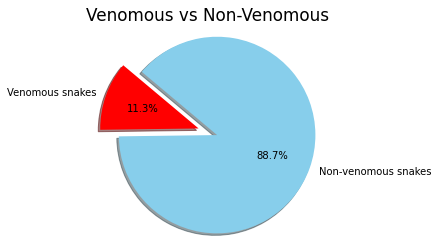

In [16]:
labels = 'Venomous snakes', 'Non-venomous snakes'
sizes = [6, 47]  
colors = ['red', 'skyblue']  
explode = (0.2, 0)  


plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.title('Venomous vs Non-Venomous')
plt.show()

In [17]:
venomous_snake_names = ["Harlequin Coralsnake", "Dusky Pygmy Rattlesnake", "Eastern Diamond-backed Rattlesnake", "Eastern Copperhead", "Florida Cottonmouth", "Timber Rattlesnake"]
print(venomous_snake_names)

['Harlequin Coralsnake', 'Dusky Pygmy Rattlesnake', 'Eastern Diamond-backed Rattlesnake', 'Eastern Copperhead', 'Florida Cottonmouth', 'Timber Rattlesnake']


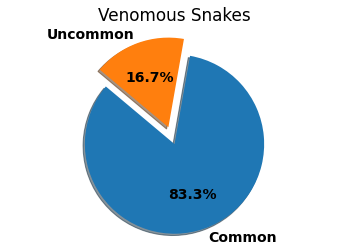

In [18]:
labels = ['Common', 'Uncommon']
counts = [5, 1]  
explode = (0.2, 0)

plt.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.title('Venomous Snakes')
plt.show()

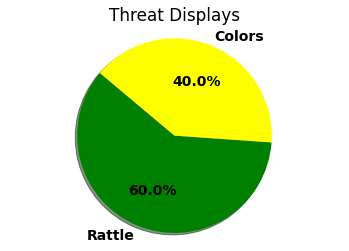

In [19]:
labels = ['Rattle', 'Colors']
counts = [3, 2] 
colors = ['green', 'yellow']
explode = (0.2, 0)


plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)
plt.axis('equal') 
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.title('Threat Displays')
plt.show()